In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



In [2]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt

def SIR_diffparam(z, t, beta, beta2, gamma, gamma2, errato = 0):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta2 * I * S / N - gamma * I
    dR = gamma2 * I 

    dzdt = [dS, dI, dR]
    return dzdt

# adattare il modello tempo-variabile -> così da considerare lockdown ecc? -> o con alcuni threshold

def plot_traj(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %R0 )
    plt.savefig('SIR.pdf', dpi=300)
    
def plot_traj_gray(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, color = 'lightgray')
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')

In [3]:
# oop con ereditarietà?

def SEIR(z, t, beta, gamma, lamb, mu, a):

    S, E, I, R = z

    dS = - beta * I * S / N 
    dE = beta * I * S / N - a * E
    dI = a * E - gamma  * I
    dR = gamma * I 

    dzdt = [dS, dE, dI, dR]
    return dzdt

def plot_traj_SEIR(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    x4 = trajectories[:,3]
    
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    r = plt.plot(x2, linewidth = width, label = 'Exposed')
    i = plt.plot(x3, linewidth = width, label = 'Infected')
    r = plt.plot(x4, linewidth = width, label = 'Removed')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %(a*beta/gamma) )
    plt.show()

In [4]:
data_size = 100

batch_time = 2  # tempo delle batches
niters = 500
#batch_size = 84  # dimensione delle batches
batch_size = data_size - batch_time - 1

N = 60000
infected_0 = 100
beta = 0.3 # farli time evolving?
gamma = 0.1

R0 = beta/gamma

In [5]:
t_grid = np.linspace(0, data_size-1, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions
true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento

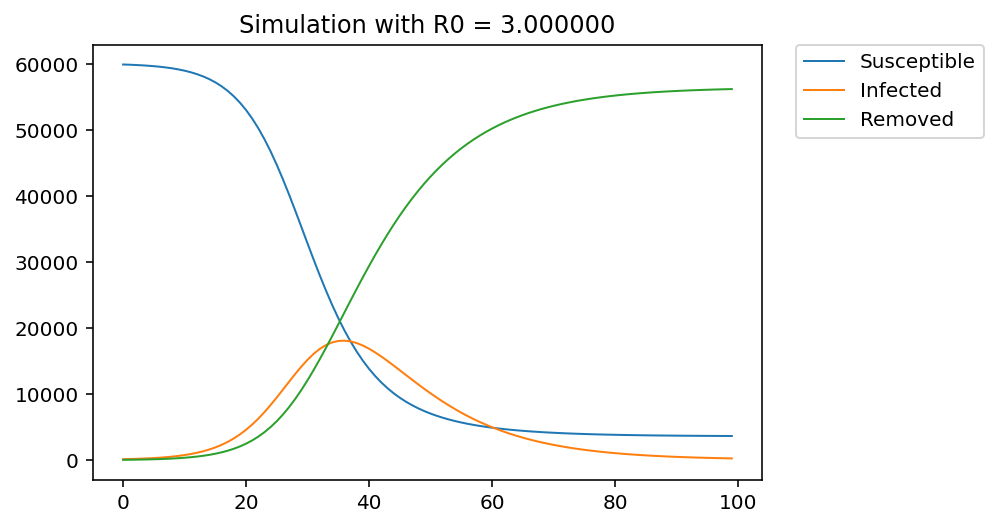

In [6]:
plot_traj(true_yy)

In [7]:

true_y = true_yy.copy()



from stochastic.processes.continuous import FractionalBrownianMotion

fbm = FractionalBrownianMotion(hurst=0.2, t= data_size)
# in questo modo è autocorrelato negativamente -> giorno da tanti tamponi seguito da giorno da pochi tamponi

noise = abs(N/200 * fbm.sample(data_size-1))
noise_2 = abs(N/200 * fbm.sample(data_size-1))


true_y[:,0] = abs(true_y[:,0] - noise)        
true_y[:,1] = abs(true_y[:,1] + noise - noise_2)
true_y[:,2] = N - true_y[:,0] - true_y[:,1]

# problema in realtà è che i suscettibili e i rimossi possono crescere/decrescere




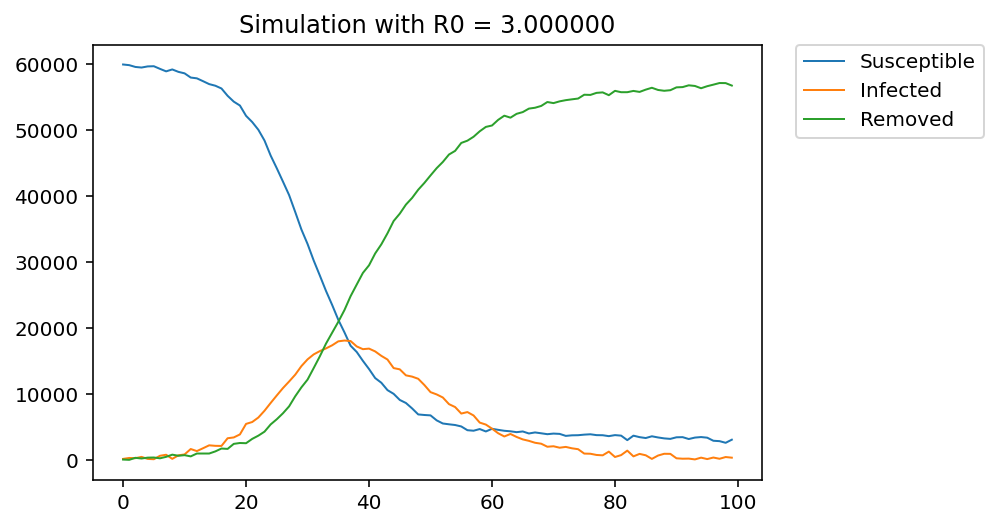

In [10]:
#true_y = true_yy
plot_traj(true_y)

In [26]:
sigma_s = np.std(true_y[:,0:1])  
sigma_i = np.std(true_y[:,1:2]) 
sigma_r = np.std(true_y[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

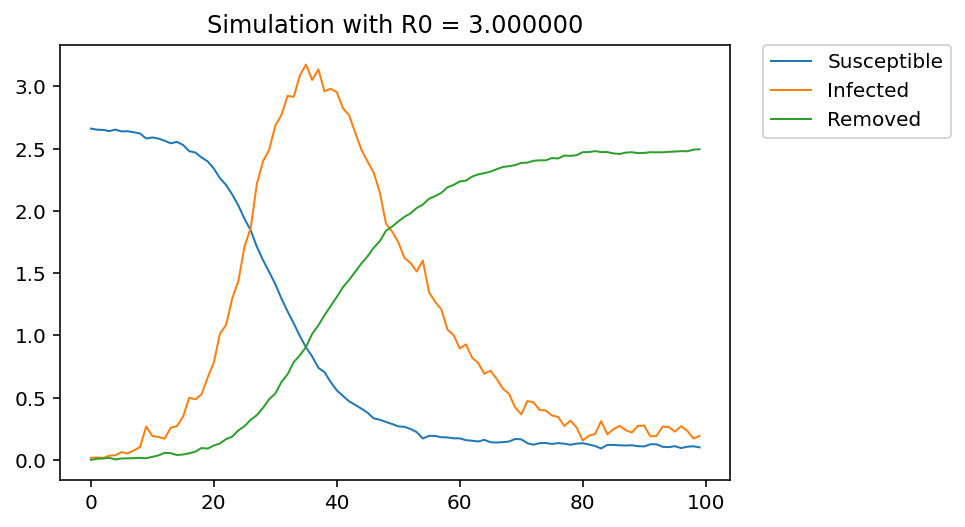

In [27]:
plot_traj(true_y)

In [28]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [29]:
num_param = 2 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch



In [30]:
from neural_ode import NeuralODE

In [31]:
niters_pre = 500  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]

        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [32]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

#parameters_pre = np.zeros((para_num, niters_pre))
parameters_pre = np.zeros((para_num, 1))

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    #parameters_pre[:,step] = np.reshape(model_pre.trainable_weights[0].numpy(),(5,))
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.18it/s]

[[0.30705395]
 [0.09859528]]


In [33]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        
        dS = - p1 * I * S / N 
        dI = p1 * I * S / N - p2 * I 
        dR = p2 * I 
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(2, 1) here


In [34]:
def kinetic_energy(V, loggamma_v, loglambda_v):
    q = (np.sum(-V**2)/mom_theta - loggamma_v**2/mom_gamma - loglambda_v**2/mom_lambda)/2.0
    return q


def compute_gradient_param(dWeights, loggamma, loglambda, batch_size, para_num):
    WW = model.trainable_weights[0].numpy()
    dWeights = np.exp(loggamma)/2.0 * dWeights + np.exp(loglambda) * np.sign(WW - w_means)
    return dWeights


def compute_gradient_hyper(loss, weights, loggamma, loglambda, batch_size, para_num):
    grad_loggamma = np.exp(loggamma) * (loss/2.0 + 1.0) - (batch_size/2.0 + 1.0)
    grad_loglambda = np.exp(loglambda) * (np.sum(np.abs(weights - w_means)) + 1.0) - (para_num + 1.0)
    # This somehow computes the gradient of the hyper parameters in order to update them from step to step

    return grad_loggamma, grad_loglambda


def compute_Hamiltonian(loss, weights, loggamma, loglambda, batch_size, para_num):
    H = np.exp(loggamma)*(loss/2.0 + 1.0) + np.exp(loglambda)*(np.sum(np.abs(weights - w_means)) + 1.0) \
             - (batch_size/2.0 + 1.0) * loggamma - (para_num + 1.0) * loglambda
    return H

def leap_frog(v_in, w_in, loggamma_in, loglambda_in, loggamma_v_in, loglambda_v_in):
    # Leap frog step for Hamiltonian Monte Carlo

    model.trainable_weights[0].assign(w_in)
    v_new = v_in
    loggamma_v_new = loggamma_v_in
    loglambda_v_new = loglambda_v_in

    loggamma_new = loggamma_in
    loglambda_new = loglambda_in
    w_new = w_in

    for m in range(L):
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN) # evaluate the gradient

        dWeights = np.asarray(dWeights[0])  # make the gradient to be numpy array
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Computation of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # 2nd component of velocity
        v_new = v_new - epsilon/2*(dWeights)  # 3rd component of velocity
        w_new = model.trainable_weights[0].numpy() + epsilon / mom_theta * v_new  # updating of x_1
        model.trainable_weights[0].assign(w_new)  # Assignment
        loggamma_new = loggamma_new + epsilon / mom_gamma * loggamma_v_new  # Updating of x_2
        loglambda_new = loglambda_new + epsilon / mom_lambda * loglambda_v_new  # Updating of x_3

        # Second half of the leap frog
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN)
        dWeights = np.asarray(dWeights[0])
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        v_new = v_new - epsilon/2*(dWeights)  # Updating of new velocities
        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Updating of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # Updating of new velocities

    return v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new


neural_ode_test = NeuralODE(model, t=t_grid[0:data_size:20])
parameters = np.zeros((niters, para_num))  # book keeping the parameters
loggammalist = np.zeros((niters, 1))  # book keeping the loggamma
loglambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loglikelihood = np.zeros((niters, 1))  # book keeping the loggamma
mom_theta = 0.2 # Momentum for the Hamiltonian Monte Carlo for theta parameters
mom_lambda = 0.1  # Momentum for the Hamiltonian Monte Carlo for lambda parameters
mom_gamma = 0.1  # Momentum for the Hamiltonian Monte Carlo for gamma parameters
L = 40  # leap frog step number
epsilon = 0.001  # leap frog step size  0.001
epsilon_max = 0.0002    # max 0.001  0.0002
epsilon_min = 0.0002    # max 0.001  0.0002
acc_rate = 0  # Used to compute and display the acceptance rate of the candidates
w_means = np.array([0.3, 0.1], dtype=np.float32)  # A priori means of parameters of the model
w_means = w_means.reshape(2, 1)

def compute_epsilon(step):
    # This will compute the epsilon to use in the leapfrog which is different for every step. It decreases
    # with the steps increasing in number
    coefficient = np.log(epsilon_max/epsilon_min)
    return epsilon_max * np.exp(- step * coefficient / niters)


# initial weight
w_temp = initial_weight  # The one we found from the preconditioner
print("initial_w", w_temp)
loggamma_temp = 4. + np.random.normal()
loglambda_temp = np.random.normal()

model.trainable_weights[0].assign(w_temp)  # We assign to the weights of the model, the ones we found through
# the pre conditioner. Remember that the initial weights set by the initializer were random distributed according
# to a Gaussian with 0 mean and 0.01 sd.
loss_original, _ = compute_gradients_and_update(batch_y0, batch_yN)  # Compute the initial Hamiltonian

loggamma_temp = np.log(batch_size / loss_original)  # We define an initial guess for loggamma ?? Why defined as such?

#loggamma_temp = -0.5

print("This is the initial guess of log(gamma)", loggamma_temp, "with loss", loss_original)
if loggamma_temp > 6.:
    loggamma_temp = 6.
    epsilon_max = 0.0002
    epsilon_min = 0.0002

# training steps
for step in tqdm(range(niters)):

    epsilon = compute_epsilon(step)  # Compute the adaptive epsilon for the steps
    v_initial = np.sqrt(mom_theta)*np.random.randn(para_num, 1)  # initialize the velocity
    loggamma_v_initial = np.sqrt(mom_gamma)*np.random.normal()
    loglambda_v_initial = np.sqrt(mom_lambda)*np.random.normal()

    loss_initial, _ = compute_gradients_and_update(batch_y0, batch_yN)  # compute the initial Hamiltonian
    # This line uses the weights of the preconditioner (see line 303) to compute the loss function with those
    loss_initial = compute_Hamiltonian(loss_initial, w_temp, loggamma_temp, loglambda_temp, batch_size, para_num)
    # Then it computes the Hamiltonian

    v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new = \
                            leap_frog(v_initial, w_temp, loggamma_temp, loglambda_temp, loggamma_v_initial, loglambda_v_initial)

    # Then the leapfrog is applied in order to update the parameters and the hyper parameters and to further
    # optimize the weights estimation (L steps of leapfrog at a time)

    # compute the final Hamiltonian, using the updated sampled weights found through leapfrog
    loss_finial, _ = compute_gradients_and_update(batch_y0, batch_yN)
    loss_finial = compute_Hamiltonian(loss_finial, w_new, loggamma_new, loglambda_new, batch_size, para_num)

    # making decisions
    p_temp = np.exp(-loss_finial + loss_initial + \
                    kinetic_energy(v_new, loggamma_v_new, loglambda_v_new) - kinetic_energy(v_initial, loggamma_v_initial, loglambda_v_initial))

    p = min(1, p_temp)
    p_decision = np.random.uniform()
    if p > p_decision:
        parameters[step:step+1, :] = np.transpose(w_new)  # Parameters are updated
        w_temp = w_new
        loggammalist[step, 0] = loggamma_new
        loglambdalist[step, 0] = loglambda_new
        loglikelihood[step, 0] = loss_finial
        loggamma_temp = loggamma_new
        loglambda_temp = loglambda_new
        acc_rate += 1
    else:
        parameters[step:step+1, :] = np.transpose(w_temp)  # New parameters are not updated
        model.trainable_weights[0].assign(w_temp)
        loggammalist[step, 0] = loggamma_temp
        loglambdalist[step, 0] = loglambda_temp
        loglikelihood[step, 0] = loss_initial

    #print('Probability of acceptance: ', p)
    #print('Accepted: ', p > p_decision)
    print(parameters[step:step+1, :])

print('Acceptance rate: ', acc_rate/niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('loggammalist', loggammalist)  # The Monte Carlo chain of loggamma
np.save('loglikelihood', loglikelihood)  # The Monte Carlo chain of losses


initial_w [[0.30705395]
 [0.09859528]]


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

This is the initial guess of log(gamma) 3.700216 with loss tf.Tensor(1.9527369, shape=(), dtype=float32)


  0%|▏                                                                                 | 1/500 [00:04<37:42,  4.53s/it]

[[0.30720534 0.09854723]]


  0%|▎                                                                                 | 2/500 [00:09<37:41,  4.54s/it]

[[0.30709393 0.09888943]]


  1%|▍                                                                                 | 3/500 [00:13<37:36,  4.54s/it]

[[0.30728275 0.09893412]]


  1%|▋                                                                                 | 4/500 [00:18<37:34,  4.55s/it]

[[0.30792559 0.0980912 ]]


  1%|▊                                                                                 | 5/500 [00:22<37:29,  4.54s/it]

[[0.30738412 0.09909874]]


  1%|▉                                                                                 | 6/500 [00:27<37:22,  4.54s/it]

[[0.30711179 0.0983256 ]]


  1%|█▏                                                                                | 7/500 [00:31<37:17,  4.54s/it]

[[0.30982439 0.0991039 ]]


  2%|█▎                                                                                | 8/500 [00:36<37:11,  4.54s/it]

[[0.30847378 0.09864094]]


  2%|█▍                                                                                | 9/500 [00:40<37:05,  4.53s/it]

[[0.30967601 0.10036784]]


  2%|█▌                                                                               | 10/500 [00:45<36:59,  4.53s/it]

[[0.3106677  0.10058668]]


  2%|█▊                                                                               | 11/500 [00:49<36:50,  4.52s/it]

[[0.30955219 0.10040347]]


  2%|█▉                                                                               | 12/500 [00:54<36:45,  4.52s/it]

[[0.3085965  0.09917278]]


  3%|██                                                                               | 13/500 [00:58<36:39,  4.52s/it]

[[0.30826359 0.09875867]]


  3%|██▎                                                                              | 14/500 [01:03<36:38,  4.52s/it]

[[0.30877646 0.09809828]]


  3%|██▍                                                                              | 15/500 [01:07<36:35,  4.53s/it]

[[0.30790912 0.09816267]]


  3%|██▌                                                                              | 16/500 [01:12<36:33,  4.53s/it]

[[0.30718329 0.09792211]]


  3%|██▊                                                                              | 17/500 [01:17<36:27,  4.53s/it]

[[0.3074542  0.09789772]]


  4%|██▉                                                                              | 18/500 [01:21<36:23,  4.53s/it]

[[0.30579116 0.09705282]]


  4%|███                                                                              | 19/500 [01:26<36:20,  4.53s/it]

[[0.30620449 0.09706247]]


  4%|███▏                                                                             | 20/500 [01:30<36:16,  4.53s/it]

[[0.30875708 0.09801228]]


  4%|███▍                                                                             | 21/500 [01:35<36:10,  4.53s/it]

[[0.31195729 0.09869523]]


  4%|███▌                                                                             | 22/500 [01:39<36:02,  4.52s/it]

[[0.31067987 0.0977425 ]]


  5%|███▋                                                                             | 23/500 [01:44<35:59,  4.53s/it]

[[0.3106868  0.09835436]]


  5%|███▉                                                                             | 24/500 [01:48<35:55,  4.53s/it]

[[0.30843317 0.09771786]]


  5%|████                                                                             | 25/500 [01:53<35:51,  4.53s/it]

[[0.30880423 0.09878471]]


  5%|████▏                                                                            | 26/500 [01:57<35:47,  4.53s/it]

[[0.30534906 0.09804179]]


  5%|████▎                                                                            | 27/500 [02:02<35:42,  4.53s/it]

[[0.30471796 0.09723127]]


  6%|████▌                                                                            | 28/500 [02:06<35:38,  4.53s/it]

[[0.31107652 0.0995495 ]]


  6%|████▋                                                                            | 29/500 [02:11<35:31,  4.53s/it]

[[0.30625599 0.09789323]]


  6%|████▊                                                                            | 30/500 [02:15<35:24,  4.52s/it]

[[0.3086708  0.09870564]]


  6%|█████                                                                            | 31/500 [02:20<35:18,  4.52s/it]

[[0.30727159 0.09809001]]


  6%|█████▏                                                                           | 32/500 [02:24<35:14,  4.52s/it]

[[0.30799914 0.09845709]]


  7%|█████▎                                                                           | 33/500 [02:29<35:11,  4.52s/it]

[[0.30933221 0.09883036]]


  7%|█████▌                                                                           | 34/500 [02:33<35:10,  4.53s/it]

[[0.30766541 0.09828002]]


  7%|█████▋                                                                           | 35/500 [02:38<35:05,  4.53s/it]

[[0.30763953 0.09818836]]


  7%|█████▊                                                                           | 36/500 [02:43<34:58,  4.52s/it]

[[0.30563521 0.09748325]]


  7%|█████▉                                                                           | 37/500 [02:47<34:53,  4.52s/it]

[[0.30371477 0.09779137]]


  8%|██████▏                                                                          | 38/500 [02:52<34:59,  4.54s/it]

[[0.30612528 0.09866503]]


  8%|██████▎                                                                          | 39/500 [02:56<35:19,  4.60s/it]

[[0.30793284 0.10023744]]


  8%|██████▍                                                                          | 40/500 [03:01<35:25,  4.62s/it]

[[0.3084627  0.10078925]]


  8%|██████▋                                                                          | 41/500 [03:06<35:13,  4.60s/it]

[[0.30404693 0.09825442]]


  8%|██████▊                                                                          | 42/500 [03:10<34:59,  4.58s/it]

[[0.3061139  0.09825769]]


  9%|██████▉                                                                          | 43/500 [03:15<34:53,  4.58s/it]

[[0.30063876 0.09655646]]


  9%|███████▏                                                                         | 44/500 [03:19<34:47,  4.58s/it]

[[0.30484213 0.09814405]]


  9%|███████▎                                                                         | 45/500 [03:24<34:37,  4.57s/it]

[[0.30497043 0.09811844]]


  9%|███████▍                                                                         | 46/500 [03:28<34:43,  4.59s/it]

[[0.30633002 0.09864006]]


  9%|███████▌                                                                         | 47/500 [03:33<34:30,  4.57s/it]

[[0.31230446 0.10082177]]


 10%|███████▊                                                                         | 48/500 [03:38<34:29,  4.58s/it]

[[0.30685255 0.09927574]]


 10%|███████▉                                                                         | 49/500 [03:42<34:25,  4.58s/it]

[[0.30531771 0.09933927]]


 10%|████████                                                                         | 50/500 [03:47<34:18,  4.57s/it]

[[0.3011068  0.09774664]]


 10%|████████▎                                                                        | 51/500 [03:51<34:13,  4.57s/it]

[[0.30332578 0.09807872]]


 10%|████████▍                                                                        | 52/500 [03:56<34:07,  4.57s/it]

[[0.31180811 0.10072287]]


 11%|████████▌                                                                        | 53/500 [04:00<34:00,  4.57s/it]

[[0.30767057 0.09850001]]


 11%|████████▋                                                                        | 54/500 [04:05<33:54,  4.56s/it]

[[0.30830989 0.09753481]]


 11%|████████▉                                                                        | 55/500 [04:10<33:46,  4.55s/it]

[[0.31371404 0.09987201]]


 11%|█████████                                                                        | 56/500 [04:14<33:38,  4.55s/it]

[[0.31173002 0.10098747]]


 11%|█████████▏                                                                       | 57/500 [04:19<33:33,  4.54s/it]

[[0.3084716  0.10074868]]


 12%|█████████▍                                                                       | 58/500 [04:23<33:26,  4.54s/it]

[[0.30667419 0.09812716]]


 12%|█████████▌                                                                       | 59/500 [04:28<33:22,  4.54s/it]

[[0.31080988 0.09964259]]


 12%|█████████▋                                                                       | 60/500 [04:32<33:17,  4.54s/it]

[[0.30981428 0.09915457]]


 12%|█████████▉                                                                       | 61/500 [04:37<33:13,  4.54s/it]

[[0.30328444 0.09699224]]


 12%|██████████                                                                       | 62/500 [04:41<33:08,  4.54s/it]

[[0.30883995 0.09879825]]


 13%|██████████▏                                                                      | 63/500 [04:46<33:03,  4.54s/it]

[[0.30964191 0.09978316]]


 13%|██████████▎                                                                      | 64/500 [04:50<32:59,  4.54s/it]

[[0.30830676 0.09808365]]


 13%|██████████▌                                                                      | 65/500 [04:55<32:54,  4.54s/it]

[[0.30575862 0.09922254]]


 13%|██████████▋                                                                      | 66/500 [04:59<32:50,  4.54s/it]

[[0.30640469 0.09878778]]


 13%|██████████▊                                                                      | 67/500 [05:04<32:45,  4.54s/it]

[[0.30550013 0.09813352]]


 14%|███████████                                                                      | 68/500 [05:09<32:39,  4.54s/it]

[[0.3076789  0.10082929]]


 14%|███████████▏                                                                     | 69/500 [05:13<32:36,  4.54s/it]

[[0.3130359  0.09831193]]


 14%|███████████▎                                                                     | 70/500 [05:18<32:32,  4.54s/it]

[[0.30560761 0.09768797]]


 14%|███████████▌                                                                     | 71/500 [05:22<32:27,  4.54s/it]

[[0.31151253 0.10037224]]


 14%|███████████▋                                                                     | 72/500 [05:27<32:22,  4.54s/it]

[[0.30814028 0.09906939]]


 15%|███████████▊                                                                     | 73/500 [05:31<32:27,  4.56s/it]

[[0.31010614 0.10015271]]


 15%|███████████▉                                                                     | 74/500 [05:36<32:41,  4.60s/it]

[[0.30450906 0.09729032]]


 15%|████████████▏                                                                    | 75/500 [05:41<32:34,  4.60s/it]

[[0.30450906 0.09729032]]


 15%|████████████▎                                                                    | 76/500 [05:45<32:24,  4.59s/it]

[[0.30401125 0.09603748]]


 15%|████████████▍                                                                    | 77/500 [05:50<32:15,  4.57s/it]

[[0.30682733 0.09827216]]


 16%|████████████▋                                                                    | 78/500 [05:54<32:07,  4.57s/it]

[[0.30692174 0.09754331]]


 16%|████████████▊                                                                    | 79/500 [05:59<32:09,  4.58s/it]

[[0.30332385 0.09739442]]


 16%|████████████▉                                                                    | 80/500 [06:03<32:07,  4.59s/it]

[[0.30845875 0.09919299]]


 16%|█████████████                                                                    | 81/500 [06:08<31:57,  4.58s/it]

[[0.30399343 0.09780647]]


 16%|█████████████▎                                                                   | 82/500 [06:13<31:48,  4.57s/it]

[[0.3054591  0.09814654]]


 17%|█████████████▍                                                                   | 83/500 [06:17<31:38,  4.55s/it]

[[0.30678607 0.0987567 ]]


 17%|█████████████▌                                                                   | 84/500 [06:22<31:31,  4.55s/it]

[[0.3095522  0.09949507]]


 17%|█████████████▊                                                                   | 85/500 [06:26<31:26,  4.55s/it]

[[0.30392505 0.09698052]]


 17%|█████████████▉                                                                   | 86/500 [06:31<31:22,  4.55s/it]

[[0.30926528 0.09997412]]


 17%|██████████████                                                                   | 87/500 [06:35<31:15,  4.54s/it]

[[0.30422897 0.09700922]]


 18%|██████████████▎                                                                  | 88/500 [06:40<31:10,  4.54s/it]

[[0.30636066 0.09904205]]


 18%|██████████████▍                                                                  | 89/500 [06:44<31:05,  4.54s/it]

[[0.31230952 0.09965824]]


 18%|██████████████▌                                                                  | 90/500 [06:49<31:02,  4.54s/it]

[[0.30722822 0.09977533]]


 18%|██████████████▋                                                                  | 91/500 [06:53<30:57,  4.54s/it]

[[0.30691791 0.09770143]]


 18%|██████████████▉                                                                  | 92/500 [06:58<30:51,  4.54s/it]

[[0.30646832 0.09933368]]


 19%|███████████████                                                                  | 93/500 [07:02<30:46,  4.54s/it]

[[0.30443916 0.09695085]]


 19%|███████████████▏                                                                 | 94/500 [07:07<30:42,  4.54s/it]

[[0.31294771 0.10143813]]


 19%|███████████████▍                                                                 | 95/500 [07:12<30:37,  4.54s/it]

[[0.30568246 0.09758275]]


 19%|███████████████▌                                                                 | 96/500 [07:16<30:30,  4.53s/it]

[[0.30824846 0.09935997]]


 19%|███████████████▋                                                                 | 97/500 [07:21<30:27,  4.53s/it]

[[0.31719627 0.10191903]]


 20%|███████████████▉                                                                 | 98/500 [07:25<30:24,  4.54s/it]

[[0.31141242 0.10048131]]


 20%|████████████████                                                                 | 99/500 [07:30<30:21,  4.54s/it]

[[0.30571921 0.09790116]]


 20%|████████████████                                                                | 100/500 [07:34<30:17,  4.54s/it]

[[0.30447622 0.09797084]]


 20%|████████████████▏                                                               | 101/500 [07:39<30:09,  4.54s/it]

[[0.30935026 0.09908812]]


 20%|████████████████▎                                                               | 102/500 [07:43<30:05,  4.54s/it]

[[0.31004941 0.10029818]]


 21%|████████████████▍                                                               | 103/500 [07:48<30:01,  4.54s/it]

[[0.31014778 0.09899633]]


 21%|████████████████▋                                                               | 104/500 [07:52<29:57,  4.54s/it]

[[0.30567252 0.09886141]]


 21%|████████████████▊                                                               | 105/500 [07:57<29:52,  4.54s/it]

[[0.30667989 0.09741273]]


 21%|████████████████▉                                                               | 106/500 [08:01<29:48,  4.54s/it]

[[0.30451243 0.09946789]]


 21%|█████████████████                                                               | 107/500 [08:06<29:47,  4.55s/it]

[[0.30993914 0.09852085]]


 22%|█████████████████▎                                                              | 108/500 [08:11<29:41,  4.54s/it]

[[0.29877459 0.09796027]]


 22%|█████████████████▍                                                              | 109/500 [08:15<29:36,  4.54s/it]

[[0.3094509  0.09771524]]


 22%|█████████████████▌                                                              | 110/500 [08:20<29:30,  4.54s/it]

[[0.30785374 0.10030328]]


 22%|█████████████████▊                                                              | 111/500 [08:24<29:26,  4.54s/it]

[[0.30733916 0.09788903]]


 22%|█████████████████▉                                                              | 112/500 [08:29<29:22,  4.54s/it]

[[0.30262747 0.09629204]]


 23%|██████████████████                                                              | 113/500 [08:33<29:17,  4.54s/it]

[[0.30119621 0.09771865]]


 23%|██████████████████▏                                                             | 114/500 [08:38<29:13,  4.54s/it]

[[0.31578095 0.10033675]]


 23%|██████████████████▍                                                             | 115/500 [08:42<29:08,  4.54s/it]

[[0.30307271 0.09819313]]


 23%|██████████████████▌                                                             | 116/500 [08:47<29:03,  4.54s/it]

[[0.30197533 0.09614251]]


 23%|██████████████████▋                                                             | 117/500 [08:51<28:59,  4.54s/it]

[[0.3105194  0.10051056]]


 24%|██████████████████▉                                                             | 118/500 [08:56<28:55,  4.54s/it]

[[0.3128482 0.0997088]]


 24%|███████████████████                                                             | 119/500 [09:00<28:49,  4.54s/it]

[[0.30143532 0.09703728]]


 24%|███████████████████▏                                                            | 120/500 [09:05<28:46,  4.54s/it]

[[0.30657076 0.09782688]]


 24%|███████████████████▎                                                            | 121/500 [09:10<28:41,  4.54s/it]

[[0.3108546  0.10010951]]


 24%|███████████████████▌                                                            | 122/500 [09:14<28:37,  4.54s/it]

[[0.31024468 0.09943824]]


 25%|███████████████████▋                                                            | 123/500 [09:19<28:33,  4.54s/it]

[[0.30348364 0.09795507]]


 25%|███████████████████▊                                                            | 124/500 [09:23<28:28,  4.54s/it]

[[0.3127912  0.09951438]]


 25%|████████████████████                                                            | 125/500 [09:28<28:22,  4.54s/it]

[[0.30495421 0.09930347]]


 25%|████████████████████▏                                                           | 126/500 [09:32<28:13,  4.53s/it]

[[0.30815228 0.09737754]]


 25%|████████████████████▎                                                           | 127/500 [09:37<28:08,  4.53s/it]

[[0.30445612 0.09915774]]


 26%|████████████████████▍                                                           | 128/500 [09:41<28:02,  4.52s/it]

[[0.31563466 0.10035598]]


 26%|████████████████████▋                                                           | 129/500 [09:46<27:57,  4.52s/it]

[[0.29704936 0.09632039]]


 26%|████████████████████▊                                                           | 130/500 [09:50<27:54,  4.53s/it]

[[0.31544286 0.10037343]]


 26%|████████████████████▉                                                           | 131/500 [09:55<27:52,  4.53s/it]

[[0.30371238 0.09921731]]


 26%|█████████████████████                                                           | 132/500 [09:59<27:52,  4.54s/it]

[[0.31211923 0.09881308]]


 27%|█████████████████████▎                                                          | 133/500 [10:04<27:45,  4.54s/it]

[[0.30482871 0.09946073]]


 27%|█████████████████████▍                                                          | 134/500 [10:09<27:41,  4.54s/it]

[[0.30477855 0.09582988]]


 27%|█████████████████████▌                                                          | 135/500 [10:13<27:37,  4.54s/it]

[[0.3072564  0.10066344]]


 27%|█████████████████████▊                                                          | 136/500 [10:18<27:34,  4.54s/it]

[[0.3018274  0.09491309]]


 27%|█████████████████████▉                                                          | 137/500 [10:22<27:35,  4.56s/it]

[[0.30922691 0.10130531]]


 28%|██████████████████████                                                          | 138/500 [10:27<27:29,  4.56s/it]

[[0.31560091 0.10012895]]


 28%|██████████████████████▏                                                         | 139/500 [10:31<27:30,  4.57s/it]

[[0.3075976  0.10066806]]


 28%|██████████████████████▍                                                         | 140/500 [10:36<27:25,  4.57s/it]

[[0.30567261 0.09661533]]


 28%|██████████████████████▌                                                         | 141/500 [10:41<27:22,  4.58s/it]

[[0.31162752 0.10209727]]


 28%|██████████████████████▋                                                         | 142/500 [10:45<27:16,  4.57s/it]

[[0.30705212 0.09640321]]


 29%|██████████████████████▉                                                         | 143/500 [10:50<27:14,  4.58s/it]

[[0.30423734 0.10016447]]


 29%|███████████████████████                                                         | 144/500 [10:54<27:05,  4.57s/it]

[[0.3072113  0.09636377]]


 29%|███████████████████████▏                                                        | 145/500 [10:59<26:57,  4.56s/it]

[[0.30433063 0.0987808 ]]


 29%|███████████████████████▎                                                        | 146/500 [11:03<26:51,  4.55s/it]

[[0.30573384 0.09754091]]


 29%|███████████████████████▌                                                        | 147/500 [11:08<26:43,  4.54s/it]

[[0.31556913 0.10240921]]


 30%|███████████████████████▋                                                        | 148/500 [11:12<26:36,  4.54s/it]

[[0.30458182 0.09723667]]


 30%|███████████████████████▊                                                        | 149/500 [11:17<26:30,  4.53s/it]

[[0.3112909  0.10006576]]


 30%|████████████████████████                                                        | 150/500 [11:21<26:26,  4.53s/it]

[[0.30713164 0.09954216]]


 30%|████████████████████████▏                                                       | 151/500 [11:26<26:20,  4.53s/it]

[[0.30844855 0.10137706]]


 30%|████████████████████████▎                                                       | 152/500 [11:30<26:16,  4.53s/it]

[[0.30677502 0.09722931]]


 31%|████████████████████████▍                                                       | 153/500 [11:35<26:12,  4.53s/it]

[[0.30944241 0.09988035]]


 31%|████████████████████████▋                                                       | 154/500 [11:40<26:06,  4.53s/it]

[[0.30868265 0.09852656]]


 31%|████████████████████████▊                                                       | 155/500 [11:44<26:03,  4.53s/it]

[[0.31241091 0.10116447]]


 31%|████████████████████████▉                                                       | 156/500 [11:49<25:59,  4.53s/it]

[[0.30633625 0.09695723]]


 31%|█████████████████████████                                                       | 157/500 [11:53<25:54,  4.53s/it]

[[0.31208987 0.1011823 ]]


 32%|█████████████████████████▎                                                      | 158/500 [11:58<25:50,  4.53s/it]

[[0.30607076 0.09703437]]


 32%|█████████████████████████▍                                                      | 159/500 [12:02<25:44,  4.53s/it]

[[0.3050653  0.09994656]]


 32%|█████████████████████████▌                                                      | 160/500 [12:07<25:39,  4.53s/it]

[[0.30606901 0.09636204]]


 32%|█████████████████████████▊                                                      | 161/500 [12:11<25:34,  4.53s/it]

[[0.30182129 0.0973653 ]]


 32%|█████████████████████████▉                                                      | 162/500 [12:16<25:29,  4.52s/it]

[[0.30812075 0.09809974]]


 33%|██████████████████████████                                                      | 163/500 [12:20<25:24,  4.52s/it]

[[0.30320621 0.09779221]]


 33%|██████████████████████████▏                                                     | 164/500 [12:25<25:20,  4.53s/it]

[[0.30709698 0.09787981]]


 33%|██████████████████████████▍                                                     | 165/500 [12:29<25:16,  4.53s/it]

[[0.30752989 0.09873499]]


 33%|██████████████████████████▌                                                     | 166/500 [12:34<25:12,  4.53s/it]

[[0.30620238 0.09696294]]


 33%|██████████████████████████▋                                                     | 167/500 [12:38<25:07,  4.53s/it]

[[0.31144243 0.10062617]]


 34%|██████████████████████████▉                                                     | 168/500 [12:43<25:04,  4.53s/it]

[[0.3022193  0.09643488]]


 34%|███████████████████████████                                                     | 169/500 [12:47<24:58,  4.53s/it]

[[0.30742469 0.09778681]]


 34%|███████████████████████████▏                                                    | 170/500 [12:52<24:54,  4.53s/it]

[[0.30860806 0.10021179]]


 34%|███████████████████████████▎                                                    | 171/500 [12:56<24:49,  4.53s/it]

[[0.30502649 0.09746315]]


 34%|███████████████████████████▌                                                    | 172/500 [13:01<24:44,  4.53s/it]

[[0.31255106 0.10194657]]


 35%|███████████████████████████▋                                                    | 173/500 [13:06<24:40,  4.53s/it]

[[0.30684411 0.09578209]]


 35%|███████████████████████████▊                                                    | 174/500 [13:10<24:35,  4.53s/it]

[[0.30530287 0.09868118]]


 35%|████████████████████████████                                                    | 175/500 [13:15<24:32,  4.53s/it]

[[0.3066145  0.09885085]]


 35%|████████████████████████████▏                                                   | 176/500 [13:19<24:27,  4.53s/it]

[[0.30753797 0.09789522]]


 35%|████████████████████████████▎                                                   | 177/500 [13:24<24:22,  4.53s/it]

[[0.30502573 0.09881563]]


 36%|████████████████████████████▍                                                   | 178/500 [13:28<24:17,  4.53s/it]

[[0.30863244 0.09714502]]


 36%|████████████████████████████▋                                                   | 179/500 [13:33<24:12,  4.53s/it]

[[0.30681825 0.1001549 ]]


 36%|████████████████████████████▊                                                   | 180/500 [13:37<24:09,  4.53s/it]

[[0.31022153 0.09798597]]


 36%|████████████████████████████▉                                                   | 181/500 [13:42<24:05,  4.53s/it]

[[0.30930916 0.10049395]]


 36%|█████████████████████████████                                                   | 182/500 [13:46<24:00,  4.53s/it]

[[0.30927621 0.09873549]]


 37%|█████████████████████████████▎                                                  | 183/500 [13:51<23:55,  4.53s/it]

[[0.31186752 0.10034349]]


 37%|█████████████████████████████▍                                                  | 184/500 [13:55<23:49,  4.52s/it]

[[0.30789305 0.09884974]]


 37%|█████████████████████████████▌                                                  | 185/500 [14:00<23:45,  4.53s/it]

[[0.30735381 0.09749647]]


 37%|█████████████████████████████▊                                                  | 186/500 [14:04<23:41,  4.53s/it]

[[0.30701268 0.10155022]]


 37%|█████████████████████████████▉                                                  | 187/500 [14:09<23:37,  4.53s/it]

[[0.30114911 0.09613069]]


 38%|██████████████████████████████                                                  | 188/500 [14:13<23:32,  4.53s/it]

[[0.30781271 0.10053907]]


 38%|██████████████████████████████▏                                                 | 189/500 [14:18<23:27,  4.53s/it]

[[0.31303911 0.09715959]]


 38%|██████████████████████████████▍                                                 | 190/500 [14:23<23:22,  4.52s/it]

[[0.30668856 0.10196833]]


 38%|██████████████████████████████▌                                                 | 191/500 [14:27<23:18,  4.52s/it]

[[0.31482839 0.09702556]]


 38%|██████████████████████████████▋                                                 | 192/500 [14:32<23:14,  4.53s/it]

[[0.30613244 0.10107596]]


 39%|██████████████████████████████▉                                                 | 193/500 [14:36<23:11,  4.53s/it]

[[0.30287769 0.0977251 ]]


 39%|███████████████████████████████                                                 | 194/500 [14:41<23:06,  4.53s/it]

[[0.30969095 0.10063943]]


 39%|███████████████████████████████▏                                                | 195/500 [14:45<23:01,  4.53s/it]

[[0.30774164 0.09758449]]


 39%|███████████████████████████████▎                                                | 196/500 [14:50<22:57,  4.53s/it]

[[0.30269575 0.0983904 ]]


 39%|███████████████████████████████▌                                                | 197/500 [14:54<22:52,  4.53s/it]

[[0.31080848 0.09816356]]


 40%|███████████████████████████████▋                                                | 198/500 [14:59<22:48,  4.53s/it]

[[0.31095759 0.10091018]]


 40%|███████████████████████████████▊                                                | 199/500 [15:03<22:43,  4.53s/it]

[[0.30913359 0.0986841 ]]


 40%|████████████████████████████████                                                | 200/500 [15:08<22:39,  4.53s/it]

[[0.30593147 0.09866151]]


 40%|████████████████████████████████▏                                               | 201/500 [15:12<22:35,  4.53s/it]

[[0.30531107 0.09851134]]


 40%|████████████████████████████████▎                                               | 202/500 [15:17<22:31,  4.53s/it]

[[0.30803415 0.09924782]]


 41%|████████████████████████████████▍                                               | 203/500 [15:21<22:26,  4.53s/it]

[[0.31183478 0.10079518]]


 41%|████████████████████████████████▋                                               | 204/500 [15:26<22:21,  4.53s/it]

[[0.30009175 0.09858395]]


 41%|████████████████████████████████▊                                               | 205/500 [15:31<22:17,  4.54s/it]

[[0.30980017 0.09824593]]


 41%|████████████████████████████████▉                                               | 206/500 [15:35<22:12,  4.53s/it]

[[0.30145039 0.09785934]]


 41%|█████████████████████████████████                                               | 207/500 [15:40<22:07,  4.53s/it]

[[0.31050268 0.09907552]]


 42%|█████████████████████████████████▎                                              | 208/500 [15:44<22:02,  4.53s/it]

[[0.3066279 0.0989086]]


 42%|█████████████████████████████████▍                                              | 209/500 [15:49<21:57,  4.53s/it]

[[0.30393473 0.09708332]]


 42%|█████████████████████████████████▌                                              | 210/500 [15:53<21:51,  4.52s/it]

[[0.31016901 0.1007907 ]]


 42%|█████████████████████████████████▊                                              | 211/500 [15:58<21:47,  4.52s/it]

[[0.30757937 0.09771967]]


 42%|█████████████████████████████████▉                                              | 212/500 [16:02<21:42,  4.52s/it]

[[0.30518312 0.09857929]]


 43%|██████████████████████████████████                                              | 213/500 [16:07<21:37,  4.52s/it]

[[0.31227513 0.10047643]]


 43%|██████████████████████████████████▏                                             | 214/500 [16:11<21:33,  4.52s/it]

[[0.30474648 0.09870069]]


 43%|██████████████████████████████████▍                                             | 215/500 [16:16<21:29,  4.52s/it]

[[0.30954849 0.09811004]]


 43%|██████████████████████████████████▌                                             | 216/500 [16:20<21:24,  4.52s/it]

[[0.30500415 0.09864671]]


 43%|██████████████████████████████████▋                                             | 217/500 [16:25<21:20,  4.52s/it]

[[0.31061555 0.09888295]]


 44%|██████████████████████████████████▉                                             | 218/500 [16:29<21:16,  4.53s/it]

[[0.30801477 0.10007015]]


 44%|███████████████████████████████████                                             | 219/500 [16:34<21:12,  4.53s/it]

[[0.30526168 0.09705643]]


 44%|███████████████████████████████████▏                                            | 220/500 [16:38<21:08,  4.53s/it]

[[0.30145276 0.09736177]]


 44%|███████████████████████████████████▎                                            | 221/500 [16:43<21:04,  4.53s/it]

[[0.30885512 0.09867387]]


 44%|███████████████████████████████████▌                                            | 222/500 [16:47<21:00,  4.53s/it]

[[0.30191452 0.09738083]]


 45%|███████████████████████████████████▋                                            | 223/500 [16:52<20:55,  4.53s/it]

[[0.31012637 0.09922265]]


 45%|███████████████████████████████████▊                                            | 224/500 [16:57<20:50,  4.53s/it]

[[0.30279065 0.09768377]]


 45%|████████████████████████████████████                                            | 225/500 [17:01<20:43,  4.52s/it]

[[0.30356073 0.09660976]]


 45%|████████████████████████████████████▏                                           | 226/500 [17:06<20:38,  4.52s/it]

[[0.30631359 0.09993692]]


 45%|████████████████████████████████████▎                                           | 227/500 [17:10<20:34,  4.52s/it]

[[0.30992436 0.09713507]]


 46%|████████████████████████████████████▍                                           | 228/500 [17:15<20:31,  4.53s/it]

[[0.30098524 0.09644431]]


 46%|████████████████████████████████████▋                                           | 229/500 [17:19<20:27,  4.53s/it]

[[0.31132029 0.09871002]]


 46%|████████████████████████████████████▊                                           | 230/500 [17:24<20:22,  4.53s/it]

[[0.30512904 0.09791505]]


 46%|████████████████████████████████████▉                                           | 231/500 [17:28<20:21,  4.54s/it]

[[0.31004122 0.09986633]]


 46%|█████████████████████████████████████                                           | 232/500 [17:33<20:15,  4.54s/it]

[[0.30804085 0.09783883]]


 47%|█████████████████████████████████████▎                                          | 233/500 [17:37<20:10,  4.53s/it]

[[0.30589574 0.09835159]]


 47%|█████████████████████████████████████▍                                          | 234/500 [17:42<20:04,  4.53s/it]

[[0.31133209 0.09944162]]


 47%|█████████████████████████████████████▌                                          | 235/500 [17:46<19:59,  4.53s/it]

[[0.30647698 0.0989869 ]]


 47%|█████████████████████████████████████▊                                          | 236/500 [17:51<19:54,  4.52s/it]

[[0.30216704 0.09474124]]


 47%|█████████████████████████████████████▉                                          | 237/500 [17:55<19:49,  4.52s/it]

[[0.3133806  0.10316888]]


 48%|██████████████████████████████████████                                          | 238/500 [18:00<19:45,  4.52s/it]

[[0.298678   0.09704522]]


 48%|██████████████████████████████████████▏                                         | 239/500 [18:04<19:40,  4.52s/it]

[[0.30618949 0.09904081]]


 48%|██████████████████████████████████████▍                                         | 240/500 [18:09<19:36,  4.52s/it]

[[0.3149817  0.10392829]]


 48%|██████████████████████████████████████▌                                         | 241/500 [18:13<19:31,  4.52s/it]

[[0.29743011 0.09356536]]


 48%|██████████████████████████████████████▋                                         | 242/500 [18:18<19:25,  4.52s/it]

[[0.31285328 0.09993203]]


 49%|██████████████████████████████████████▉                                         | 243/500 [18:22<19:20,  4.52s/it]

[[0.30942833 0.09974404]]


 49%|███████████████████████████████████████                                         | 244/500 [18:27<19:15,  4.51s/it]

[[0.30233407 0.09703425]]


 49%|███████████████████████████████████████▏                                        | 245/500 [18:32<19:12,  4.52s/it]

[[0.30787747 0.0989914 ]]


 49%|███████████████████████████████████████▎                                        | 246/500 [18:36<19:09,  4.52s/it]

[[0.30922473 0.0985839 ]]


 49%|███████████████████████████████████████▌                                        | 247/500 [18:41<19:05,  4.53s/it]

[[0.30051942 0.09657322]]


 50%|███████████████████████████████████████▋                                        | 248/500 [18:45<19:01,  4.53s/it]

[[0.31750756 0.1001623 ]]


 50%|███████████████████████████████████████▊                                        | 249/500 [18:50<18:56,  4.53s/it]

[[0.30101693 0.09656751]]


 50%|████████████████████████████████████████                                        | 250/500 [18:54<18:51,  4.52s/it]

[[0.3095239  0.09910336]]


 50%|████████████████████████████████████████▏                                       | 251/500 [18:59<18:47,  4.53s/it]

[[0.30789267 0.09694591]]


 50%|████████████████████████████████████████▎                                       | 252/500 [19:03<18:43,  4.53s/it]

[[0.30977743 0.0982926 ]]


 51%|████████████████████████████████████████▍                                       | 253/500 [19:08<18:38,  4.53s/it]

[[0.31096339 0.099179  ]]


 51%|████████████████████████████████████████▋                                       | 254/500 [19:12<18:35,  4.53s/it]

[[0.30577586 0.10071681]]


 51%|████████████████████████████████████████▊                                       | 255/500 [19:17<18:29,  4.53s/it]

[[0.31158106 0.09962967]]


 51%|████████████████████████████████████████▉                                       | 256/500 [19:21<18:25,  4.53s/it]

[[0.29985598 0.09661367]]


 51%|█████████████████████████████████████████                                       | 257/500 [19:26<18:20,  4.53s/it]

[[0.30518243 0.09821781]]


 52%|█████████████████████████████████████████▎                                      | 258/500 [19:30<18:14,  4.52s/it]

[[0.30797171 0.09752413]]


 52%|█████████████████████████████████████████▍                                      | 259/500 [19:35<18:10,  4.52s/it]

[[0.30694933 0.09810326]]


 52%|█████████████████████████████████████████▌                                      | 260/500 [19:39<18:05,  4.52s/it]

[[0.3109769  0.10033171]]


 52%|█████████████████████████████████████████▊                                      | 261/500 [19:44<18:00,  4.52s/it]

[[0.3061877  0.09754036]]


 52%|█████████████████████████████████████████▉                                      | 262/500 [19:48<17:55,  4.52s/it]

[[0.30986124 0.10042814]]


 53%|██████████████████████████████████████████                                      | 263/500 [19:53<17:51,  4.52s/it]

[[0.30241651 0.09670541]]


 53%|██████████████████████████████████████████▏                                     | 264/500 [19:58<17:47,  4.52s/it]

[[0.31287516 0.09986431]]


 53%|██████████████████████████████████████████▍                                     | 265/500 [20:02<17:42,  4.52s/it]

[[0.30400306 0.09880918]]


 53%|██████████████████████████████████████████▌                                     | 266/500 [20:07<17:38,  4.52s/it]

[[0.31433443 0.10011506]]


 53%|██████████████████████████████████████████▋                                     | 267/500 [20:11<17:33,  4.52s/it]

[[0.30419859 0.0992889 ]]


 54%|██████████████████████████████████████████▉                                     | 268/500 [20:16<17:29,  4.52s/it]

[[0.30465973 0.09820229]]


 54%|███████████████████████████████████████████                                     | 269/500 [20:20<17:25,  4.53s/it]

[[0.30421892 0.09753795]]


 54%|███████████████████████████████████████████▏                                    | 270/500 [20:25<17:20,  4.53s/it]

[[0.30827122 0.10018397]]


 54%|███████████████████████████████████████████▎                                    | 271/500 [20:29<17:15,  4.52s/it]

[[0.30063092 0.09664498]]


 54%|███████████████████████████████████████████▌                                    | 272/500 [20:34<17:10,  4.52s/it]

[[0.31063914 0.10057711]]


 55%|███████████████████████████████████████████▋                                    | 273/500 [20:38<17:06,  4.52s/it]

[[0.30034194 0.0956083 ]]


 55%|███████████████████████████████████████████▊                                    | 274/500 [20:43<17:02,  4.52s/it]

[[0.31025268 0.10077639]]


 55%|████████████████████████████████████████████                                    | 275/500 [20:47<16:57,  4.52s/it]

[[0.30529495 0.09815032]]


 55%|████████████████████████████████████████████▏                                   | 276/500 [20:52<16:53,  4.52s/it]

[[0.30384281 0.09763356]]


 55%|████████████████████████████████████████████▎                                   | 277/500 [20:56<16:48,  4.52s/it]

[[0.30779062 0.09807729]]


 56%|████████████████████████████████████████████▍                                   | 278/500 [21:01<16:43,  4.52s/it]

[[0.30420757 0.0983914 ]]


 56%|████████████████████████████████████████████▋                                   | 279/500 [21:05<16:38,  4.52s/it]

[[0.31421578 0.09968264]]


 56%|████████████████████████████████████████████▊                                   | 280/500 [21:10<16:34,  4.52s/it]

[[0.30849041 0.09916328]]


 56%|████████████████████████████████████████████▉                                   | 281/500 [21:14<16:29,  4.52s/it]

[[0.30885378 0.09703429]]


 56%|█████████████████████████████████████████████                                   | 282/500 [21:19<16:25,  4.52s/it]

[[0.30525698 0.09922525]]


 57%|█████████████████████████████████████████████▎                                  | 283/500 [21:23<16:20,  4.52s/it]

[[0.31156888 0.09900247]]


 57%|█████████████████████████████████████████████▍                                  | 284/500 [21:28<16:16,  4.52s/it]

[[0.30516934 0.0979903 ]]


 57%|█████████████████████████████████████████████▌                                  | 285/500 [21:32<16:13,  4.53s/it]

[[0.30588728 0.09832475]]


 57%|█████████████████████████████████████████████▊                                  | 286/500 [21:37<16:08,  4.53s/it]

[[0.30754877 0.09925309]]


 57%|█████████████████████████████████████████████▉                                  | 287/500 [21:42<16:03,  4.52s/it]

[[0.31301405 0.10085518]]


 58%|██████████████████████████████████████████████                                  | 288/500 [21:46<15:58,  4.52s/it]

[[0.30468831 0.09778005]]


 58%|██████████████████████████████████████████████▏                                 | 289/500 [21:51<15:53,  4.52s/it]

[[0.31219883 0.09995255]]


 58%|██████████████████████████████████████████████▍                                 | 290/500 [21:55<15:49,  4.52s/it]

[[0.30428314 0.09558303]]


 58%|██████████████████████████████████████████████▌                                 | 291/500 [22:00<15:45,  4.52s/it]

[[0.30949747 0.09947279]]


 58%|██████████████████████████████████████████████▋                                 | 292/500 [22:04<15:41,  4.53s/it]

[[0.30983412 0.10089332]]


 59%|██████████████████████████████████████████████▉                                 | 293/500 [22:09<15:37,  4.53s/it]

[[0.3105102  0.09893719]]


 59%|███████████████████████████████████████████████                                 | 294/500 [22:13<15:33,  4.53s/it]

[[0.30199252 0.09644968]]


 59%|███████████████████████████████████████████████▏                                | 295/500 [22:18<15:28,  4.53s/it]

[[0.31142023 0.10101229]]


 59%|███████████████████████████████████████████████▎                                | 296/500 [22:22<15:23,  4.53s/it]

[[0.30018705 0.09568671]]


 59%|███████████████████████████████████████████████▌                                | 297/500 [22:27<15:18,  4.52s/it]

[[0.31282219 0.10268757]]


 60%|███████████████████████████████████████████████▋                                | 298/500 [22:31<15:13,  4.52s/it]

[[0.30307471 0.09896279]]


 60%|███████████████████████████████████████████████▊                                | 299/500 [22:36<15:08,  4.52s/it]

[[0.31263756 0.10077944]]


 60%|████████████████████████████████████████████████                                | 300/500 [22:40<15:04,  4.52s/it]

[[0.30348623 0.09691762]]


 60%|████████████████████████████████████████████████▏                               | 301/500 [22:45<14:59,  4.52s/it]

[[0.30582219 0.09697713]]


 60%|████████████████████████████████████████████████▎                               | 302/500 [22:49<14:55,  4.52s/it]

[[0.31144288 0.10034682]]


 61%|████████████████████████████████████████████████▍                               | 303/500 [22:54<14:52,  4.53s/it]

[[0.30259931 0.09655936]]


 61%|████████████████████████████████████████████████▋                               | 304/500 [22:58<14:47,  4.53s/it]

[[0.31453538 0.10124109]]


 61%|████████████████████████████████████████████████▊                               | 305/500 [23:03<14:41,  4.52s/it]

[[0.29871562 0.09674024]]


 61%|████████████████████████████████████████████████▉                               | 306/500 [23:07<14:37,  4.52s/it]

[[0.31573026 0.10119507]]


 61%|█████████████████████████████████████████████████                               | 307/500 [23:12<14:32,  4.52s/it]

[[0.30351812 0.09626607]]


 62%|█████████████████████████████████████████████████▎                              | 308/500 [23:17<14:28,  4.52s/it]

[[0.30992041 0.10008061]]


 62%|█████████████████████████████████████████████████▍                              | 309/500 [23:21<14:23,  4.52s/it]

[[0.30450279 0.09599431]]


 62%|█████████████████████████████████████████████████▌                              | 310/500 [23:26<14:19,  4.53s/it]

[[0.30793518 0.09806193]]


 62%|█████████████████████████████████████████████████▊                              | 311/500 [23:30<14:15,  4.52s/it]

[[0.30859348 0.1010043 ]]


 62%|█████████████████████████████████████████████████▉                              | 312/500 [23:35<14:10,  4.52s/it]

[[0.30603462 0.09925463]]


 63%|██████████████████████████████████████████████████                              | 313/500 [23:39<14:05,  4.52s/it]

[[0.30494567 0.09725656]]


 63%|██████████████████████████████████████████████████▏                             | 314/500 [23:44<14:01,  4.52s/it]

[[0.31288532 0.09960689]]


 63%|██████████████████████████████████████████████████▍                             | 315/500 [23:48<13:56,  4.52s/it]

[[0.30383529 0.09671829]]


 63%|██████████████████████████████████████████████████▌                             | 316/500 [23:53<13:52,  4.52s/it]

[[0.31135527 0.09991124]]


 63%|██████████████████████████████████████████████████▋                             | 317/500 [23:57<13:47,  4.52s/it]

[[0.30620965 0.10065708]]


 64%|██████████████████████████████████████████████████▉                             | 318/500 [24:02<13:43,  4.53s/it]

[[0.30515333 0.09883857]]


 64%|███████████████████████████████████████████████████                             | 319/500 [24:06<13:39,  4.53s/it]

[[0.30535761 0.09809746]]


 64%|███████████████████████████████████████████████████▏                            | 320/500 [24:11<13:35,  4.53s/it]

[[0.30663975 0.10016444]]


 64%|███████████████████████████████████████████████████▎                            | 321/500 [24:15<13:30,  4.53s/it]

[[0.30736675 0.0991088 ]]


 64%|███████████████████████████████████████████████████▌                            | 322/500 [24:20<13:26,  4.53s/it]

[[0.30442079 0.09666619]]


 65%|███████████████████████████████████████████████████▋                            | 323/500 [24:24<13:21,  4.53s/it]

[[0.31004559 0.09863949]]


 65%|███████████████████████████████████████████████████▊                            | 324/500 [24:29<13:16,  4.53s/it]

[[0.29930768 0.09672532]]


 65%|████████████████████████████████████████████████████                            | 325/500 [24:33<13:10,  4.52s/it]

[[0.31534915 0.10185116]]


 65%|████████████████████████████████████████████████████▏                           | 326/500 [24:38<13:06,  4.52s/it]

[[0.29198129 0.09262921]]


 65%|████████████████████████████████████████████████████▎                           | 327/500 [24:43<13:02,  4.52s/it]

[[0.31755305 0.10173241]]


 66%|████████████████████████████████████████████████████▍                           | 328/500 [24:47<12:58,  4.53s/it]

[[0.29784192 0.09740857]]


 66%|████████████████████████████████████████████████████▋                           | 329/500 [24:52<12:53,  4.53s/it]

[[0.30757055 0.0983242 ]]


 66%|████████████████████████████████████████████████████▊                           | 330/500 [24:56<12:49,  4.52s/it]

[[0.31234271 0.09976927]]


 66%|████████████████████████████████████████████████████▉                           | 331/500 [25:01<12:44,  4.53s/it]

[[0.31234271 0.09976927]]


 66%|█████████████████████████████████████████████████████                           | 332/500 [25:05<12:39,  4.52s/it]

[[0.30110537 0.09629024]]


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [25:10<12:36,  4.53s/it]

[[0.31339943 0.09905907]]


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [25:14<12:31,  4.53s/it]

[[0.30085705 0.09722725]]


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [25:19<12:26,  4.53s/it]

[[0.30642066 0.09928134]]


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [25:23<12:22,  4.53s/it]

[[0.30199987 0.09792158]]


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [25:28<12:17,  4.53s/it]

[[0.30816832 0.09589099]]


 68%|██████████████████████████████████████████████████████                          | 338/500 [25:32<12:13,  4.53s/it]

[[0.30499237 0.101453  ]]


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [25:37<12:08,  4.53s/it]

[[0.30794024 0.10092867]]


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [25:41<12:03,  4.52s/it]

[[0.3061564  0.09804546]]


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [25:46<11:58,  4.52s/it]

[[0.30947957 0.098706  ]]


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [25:50<11:54,  4.52s/it]

[[0.30593591 0.09801644]]


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [25:55<11:50,  4.52s/it]

[[0.31171083 0.1011314 ]]


 69%|███████████████████████████████████████████████████████                         | 344/500 [25:59<11:45,  4.52s/it]

[[0.3039406  0.09504849]]


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [26:04<11:40,  4.52s/it]

[[0.30971303 0.1006261 ]]


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [26:08<11:36,  4.52s/it]

[[0.30267908 0.09641977]]


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [26:13<11:31,  4.52s/it]

[[0.30556675 0.09957817]]


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [26:18<11:27,  4.52s/it]

[[0.30896092 0.09773644]]


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [26:22<11:22,  4.52s/it]

[[0.3080194  0.09957157]]


 70%|████████████████████████████████████████████████████████                        | 350/500 [26:27<11:17,  4.52s/it]

[[0.30446127 0.0987457 ]]


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [26:31<11:12,  4.51s/it]

[[0.31037691 0.10130288]]


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [26:36<11:07,  4.51s/it]

[[0.30449381 0.0984352 ]]


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [26:40<11:03,  4.51s/it]

[[0.30740592 0.09848624]]


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [26:45<10:59,  4.52s/it]

[[0.30810079 0.09938027]]


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [26:49<10:55,  4.52s/it]

[[0.302095   0.09801156]]


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [26:54<10:51,  4.53s/it]

[[0.31265092 0.10066876]]


 71%|█████████████████████████████████████████████████████████                       | 357/500 [26:58<10:47,  4.53s/it]

[[0.30349359 0.09710929]]


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [27:03<10:42,  4.53s/it]

[[0.31222376 0.0990183 ]]


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [27:07<10:38,  4.53s/it]

[[0.30862843 0.10032446]]


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [27:12<10:33,  4.52s/it]

[[0.31304355 0.10004173]]


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [27:16<10:29,  4.53s/it]

[[0.29761698 0.09797308]]


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [27:21<10:24,  4.53s/it]

[[0.3153014  0.09984567]]


 73%|██████████████████████████████████████████████████████████                      | 363/500 [27:25<10:20,  4.53s/it]

[[0.29721339 0.0970336 ]]


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [27:30<10:15,  4.53s/it]

[[0.31107182 0.10083393]]


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [27:34<10:11,  4.53s/it]

[[0.30312396 0.09612149]]


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [27:39<10:06,  4.53s/it]

[[0.31055459 0.10146579]]


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [27:43<10:02,  4.53s/it]

[[0.30271374 0.09702132]]


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [27:48<09:57,  4.53s/it]

[[0.30749435 0.09721966]]


 74%|███████████████████████████████████████████████████████████                     | 369/500 [27:53<09:53,  4.53s/it]

[[0.3081276  0.09859903]]


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [27:57<09:48,  4.53s/it]

[[0.30829458 0.10019467]]


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [28:02<09:44,  4.53s/it]

[[0.30226407 0.09696626]]


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [28:06<09:39,  4.53s/it]

[[0.31449866 0.10111066]]


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [28:11<09:35,  4.53s/it]

[[0.30129819 0.09759021]]


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [28:15<09:30,  4.53s/it]

[[0.30778401 0.09823775]]


 75%|████████████████████████████████████████████████████████████                    | 375/500 [28:20<09:25,  4.53s/it]

[[0.30816514 0.10062425]]


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [28:24<09:21,  4.52s/it]

[[0.30212529 0.09431027]]


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [28:29<09:16,  4.52s/it]

[[0.31263484 0.10302733]]


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [28:33<09:11,  4.52s/it]

[[0.30610697 0.09617453]]


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [28:38<09:07,  4.52s/it]

[[0.30482178 0.09969079]]


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [28:42<09:02,  4.52s/it]

[[0.30892364 0.09771518]]


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [28:47<08:57,  4.52s/it]

[[0.30689025 0.09813913]]


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [28:51<08:53,  4.52s/it]

[[0.31171436 0.0999474 ]]


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [28:56<08:49,  4.52s/it]

[[0.30122988 0.09796025]]


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [29:00<08:44,  4.52s/it]

[[0.30918816 0.09829974]]


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [29:05<08:40,  4.53s/it]

[[0.30194991 0.09880452]]


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [29:09<08:35,  4.52s/it]

[[0.30444957 0.09668203]]


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [29:14<08:31,  4.52s/it]

[[0.31246539 0.10073512]]


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [29:19<08:28,  4.54s/it]

[[0.30640035 0.09855911]]


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [29:23<08:23,  4.54s/it]

[[0.30632319 0.09826468]]


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [29:28<08:19,  4.54s/it]

[[0.30904809 0.0993959 ]]


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [29:32<08:14,  4.54s/it]

[[0.30507362 0.09821044]]


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [29:37<08:09,  4.53s/it]

[[0.30941602 0.09920568]]


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [29:41<08:04,  4.53s/it]

[[0.30871538 0.09933765]]


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [29:46<08:00,  4.53s/it]

[[0.30601539 0.0975219 ]]


 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [29:50<07:55,  4.53s/it]

[[0.30802325 0.10060726]]


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [29:55<07:51,  4.53s/it]

[[0.30711842 0.09670979]]


 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [29:59<07:46,  4.53s/it]

[[0.30748118 0.10089451]]


 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [30:04<07:41,  4.52s/it]

[[0.31472318 0.09922376]]


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [30:08<07:36,  4.52s/it]

[[0.30317704 0.09929284]]


 80%|████████████████████████████████████████████████████████████████                | 400/500 [30:13<07:31,  4.52s/it]

[[0.31378628 0.09908115]]


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [30:17<07:27,  4.52s/it]

[[0.30932121 0.10130301]]


 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [30:22<07:23,  4.52s/it]

[[0.30458575 0.09620752]]


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [30:26<07:19,  4.53s/it]

[[0.30703594 0.10045459]]


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [30:31<07:14,  4.53s/it]

[[0.30906466 0.09719523]]


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [30:36<07:10,  4.53s/it]

[[0.30800043 0.10118955]]


 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [30:40<07:05,  4.53s/it]

[[0.31023241 0.09765581]]


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [30:45<07:01,  4.53s/it]

[[0.30412818 0.09916714]]


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [30:49<06:56,  4.53s/it]

[[0.30274915 0.09606884]]


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [30:54<06:52,  4.53s/it]

[[0.31015411 0.10066119]]


 82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [30:58<06:47,  4.53s/it]

[[0.30881073 0.09824609]]


 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [31:03<06:43,  4.53s/it]

[[0.30162618 0.0976592 ]]


 82%|█████████████████████████████████████████████████████████████████▉              | 412/500 [31:07<06:38,  4.53s/it]

[[0.30937076 0.09848231]]


 83%|██████████████████████████████████████████████████████████████████              | 413/500 [31:12<06:34,  4.54s/it]

[[0.31137525 0.10070714]]


 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [31:16<06:30,  4.54s/it]

[[0.30557055 0.09724639]]


 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [31:21<06:26,  4.55s/it]

[[0.3113936 0.1008021]]


 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [31:25<06:21,  4.54s/it]

[[0.30821542 0.09809688]]


 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [31:30<06:17,  4.55s/it]

[[0.30246706 0.09791711]]


 84%|██████████████████████████████████████████████████████████████████▉             | 418/500 [31:34<06:12,  4.54s/it]

[[0.31137929 0.09920317]]


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [31:39<06:07,  4.54s/it]

[[0.31095049 0.10088813]]


 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [31:44<06:02,  4.54s/it]

[[0.2986723  0.09477981]]


 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [31:48<05:58,  4.53s/it]

[[0.31042348 0.10073765]]


 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [31:53<05:53,  4.53s/it]

[[0.30375349 0.09579097]]


 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [31:57<05:48,  4.53s/it]

[[0.30429283 0.09898595]]


 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [32:02<05:43,  4.53s/it]

[[0.30637216 0.09723009]]


 85%|████████████████████████████████████████████████████████████████████            | 425/500 [32:06<05:39,  4.53s/it]

[[0.30722259 0.10016487]]


 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [32:11<05:35,  4.53s/it]

[[0.30468038 0.09638592]]


 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [32:15<05:30,  4.53s/it]

[[0.30611385 0.09986663]]


 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [32:20<05:26,  4.53s/it]

[[0.30824021 0.09770276]]


 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [32:24<05:22,  4.54s/it]

[[0.30603482 0.09947864]]


 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [32:29<05:17,  4.54s/it]

[[0.30624252 0.09759963]]


 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [32:33<05:12,  4.54s/it]

[[0.30505143 0.09867418]]


 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [32:38<05:08,  4.54s/it]

[[0.2998645  0.09488953]]


 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [32:42<05:03,  4.53s/it]

[[0.31057321 0.10026342]]


 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [32:47<04:59,  4.53s/it]

[[0.31358546 0.1004635 ]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [32:52<04:54,  4.53s/it]

[[0.30019088 0.09709098]]


 87%|█████████████████████████████████████████████████████████████████████▊          | 436/500 [32:56<04:50,  4.54s/it]

[[0.3083948  0.09845311]]


 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [33:01<04:45,  4.54s/it]

[[0.30373097 0.09879652]]


 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [33:05<04:41,  4.54s/it]

[[0.30569578 0.09854118]]


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [33:10<04:36,  4.53s/it]

[[0.30785111 0.09854615]]


 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [33:14<04:32,  4.54s/it]

[[0.30817016 0.09928027]]


 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [33:19<04:27,  4.54s/it]

[[0.30695894 0.09747978]]


 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [33:23<04:23,  4.54s/it]

[[0.30807842 0.09922776]]


 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [33:28<04:18,  4.54s/it]

[[0.30886154 0.09892063]]


 89%|███████████████████████████████████████████████████████████████████████         | 444/500 [33:32<04:13,  4.53s/it]

[[0.30990425 0.09908251]]


 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [33:37<04:09,  4.53s/it]

[[0.30910587 0.10122262]]


 89%|███████████████████████████████████████████████████████████████████████▎        | 446/500 [33:41<04:04,  4.52s/it]

[[0.31153567 0.098097  ]]


 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [33:46<03:59,  4.52s/it]

[[0.30545577 0.09944501]]


 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [33:50<03:55,  4.52s/it]

[[0.30473047 0.09647186]]


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [33:55<03:50,  4.52s/it]

[[0.31029569 0.10168514]]


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [33:59<03:45,  4.52s/it]

[[0.31549707 0.09971057]]


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [34:04<03:41,  4.52s/it]

[[0.30372085 0.09928847]]


 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [34:08<03:36,  4.52s/it]

[[0.30368951 0.09438427]]


 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [34:13<03:32,  4.52s/it]

[[0.30485739 0.10131803]]


 91%|████████████████████████████████████████████████████████████████████████▋       | 454/500 [34:18<03:27,  4.52s/it]

[[0.31325411 0.09794172]]


 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [34:22<03:23,  4.52s/it]

[[0.30513938 0.1014316 ]]


 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [34:27<03:18,  4.52s/it]

[[0.31422625 0.09780214]]


 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [34:31<03:14,  4.53s/it]

[[0.30462516 0.1013741 ]]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [34:36<03:10,  4.54s/it]

[[0.31060212 0.09635264]]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [34:40<03:06,  4.54s/it]

[[0.3043977  0.09970428]]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [34:45<03:01,  4.54s/it]

[[0.30524731 0.09620343]]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [34:49<02:57,  4.54s/it]

[[0.30597013 0.09993978]]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [34:54<02:52,  4.53s/it]

[[0.3095246  0.09772965]]


 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [34:58<02:47,  4.53s/it]

[[0.30132561 0.0982976 ]]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [35:03<02:42,  4.53s/it]

[[0.31139827 0.09863599]]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [35:07<02:38,  4.53s/it]

[[0.30799063 0.10060336]]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [35:12<02:34,  4.53s/it]

[[0.31170677 0.09844243]]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [35:16<02:29,  4.54s/it]

[[0.30420933 0.09897081]]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [35:21<02:25,  4.54s/it]

[[0.30420933 0.09897081]]


 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [35:26<02:20,  4.54s/it]

[[0.31163282 0.09837407]]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [35:30<02:16,  4.54s/it]

[[0.30516397 0.09961183]]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [35:35<02:11,  4.54s/it]

[[0.3112094  0.09814142]]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 472/500 [35:39<02:07,  4.55s/it]

[[0.30440692 0.09975541]]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [35:44<02:02,  4.54s/it]

[[0.3103935  0.09763396]]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [35:48<01:58,  4.54s/it]

[[0.30362156 0.0992497 ]]


 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [35:53<01:53,  4.56s/it]

[[0.31093546 0.09822636]]


 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [35:57<01:49,  4.56s/it]

[[0.30485838 0.09985105]]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [36:02<01:44,  4.55s/it]

[[0.30840862 0.09711274]]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [36:06<01:39,  4.54s/it]

[[0.30461129 0.09917825]]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 479/500 [36:11<01:35,  4.53s/it]

[[0.31227944 0.09904625]]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [36:16<01:30,  4.53s/it]

[[0.29799035 0.09728628]]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [36:20<01:26,  4.53s/it]

[[0.30881579 0.09750741]]


 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [36:25<01:21,  4.54s/it]

[[0.30176848 0.09779752]]


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [36:29<01:17,  4.54s/it]

[[0.31378363 0.09926816]]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [36:34<01:12,  4.54s/it]

[[0.31102755 0.10151108]]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [36:38<01:08,  4.53s/it]

[[0.30458662 0.09597247]]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [36:43<01:03,  4.53s/it]

[[0.30317841 0.09857727]]


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [36:47<00:58,  4.52s/it]

[[0.30327616 0.09500545]]


 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [36:52<00:54,  4.55s/it]

[[0.31301092 0.10302214]]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [36:56<00:50,  4.55s/it]

[[0.30254721 0.0950378 ]]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [37:01<00:45,  4.55s/it]

[[0.30727358 0.10079421]]


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [37:05<00:40,  4.54s/it]

[[0.30491065 0.09590942]]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [37:10<00:36,  4.58s/it]

[[0.31412082 0.10310517]]


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [37:15<00:32,  4.58s/it]

[[0.30480811 0.09584906]]


 99%|███████████████████████████████████████████████████████████████████████████████ | 494/500 [37:19<00:27,  4.57s/it]

[[0.30445997 0.09967072]]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [37:24<00:22,  4.56s/it]

[[0.31293737 0.09893255]]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [37:28<00:18,  4.54s/it]

[[0.30935754 0.10111034]]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 497/500 [37:33<00:13,  4.55s/it]

[[0.30611101 0.0966308 ]]


100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [37:37<00:09,  4.55s/it]

[[0.30542773 0.09997694]]


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [37:42<00:04,  4.55s/it]

[[0.31130161 0.09844809]]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [37:47<00:00,  4.53s/it]

[[0.31109094 0.10182916]]
Acceptance rate:  0.994


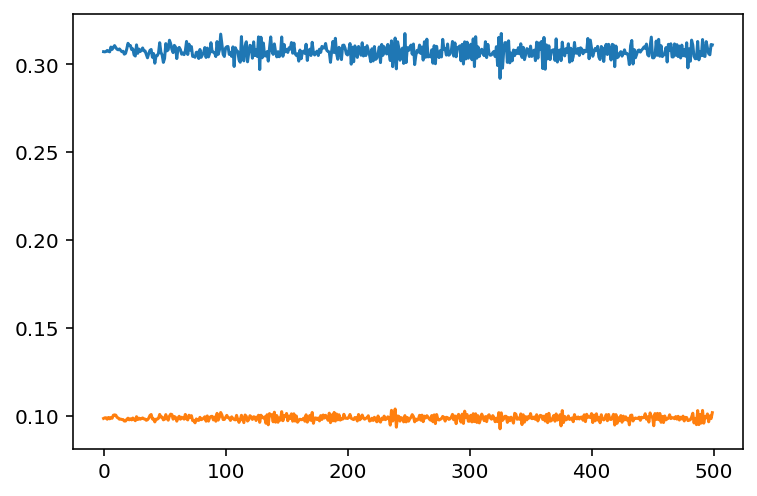

In [35]:
plt.plot(parameters)

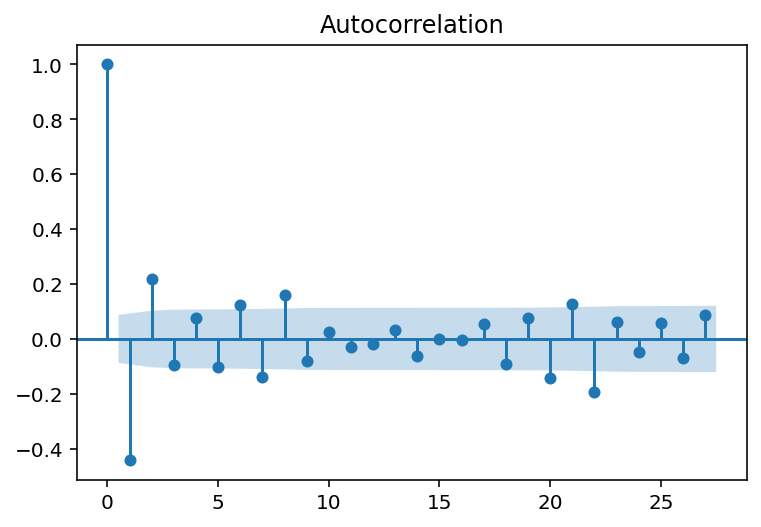

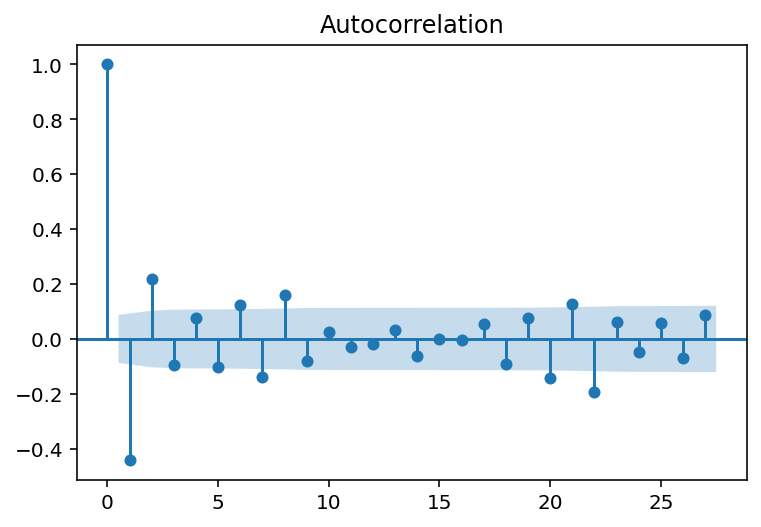

In [47]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(parameters[:,0])

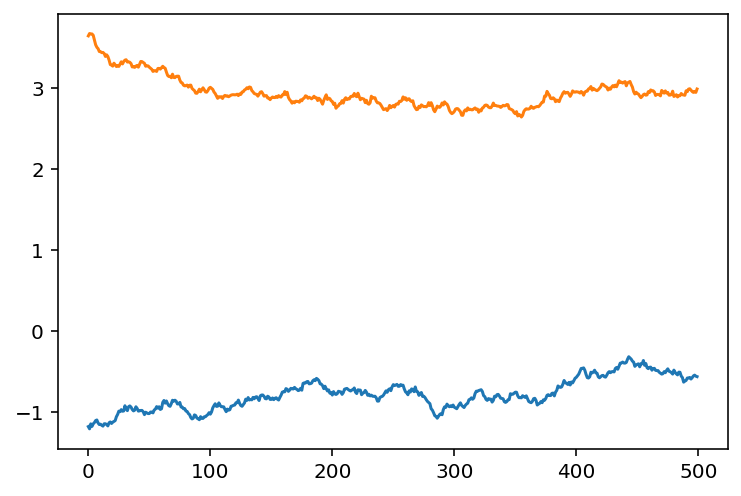

In [37]:
plt.plot(loglambdalist)
plt.plot(loggammalist)

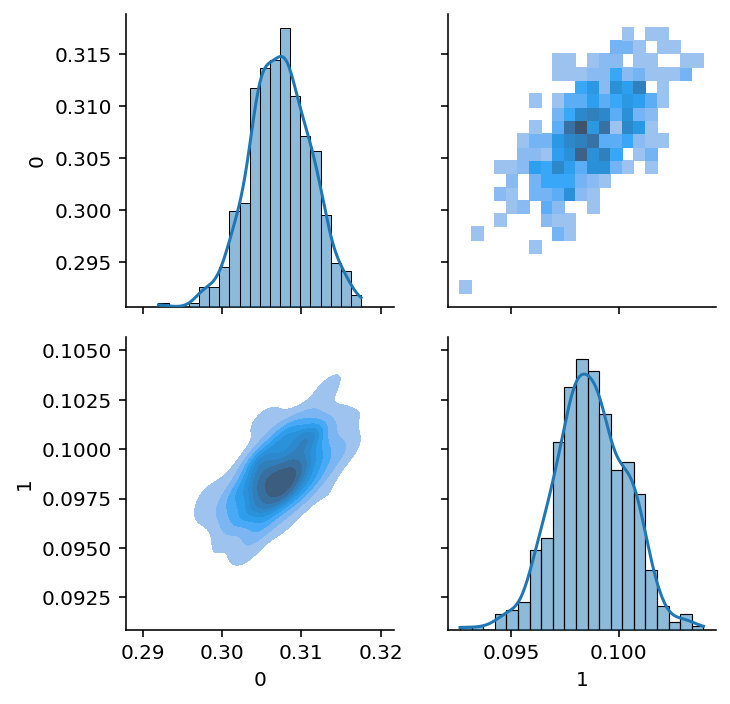

In [38]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(parameters))
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 298.32it/s]


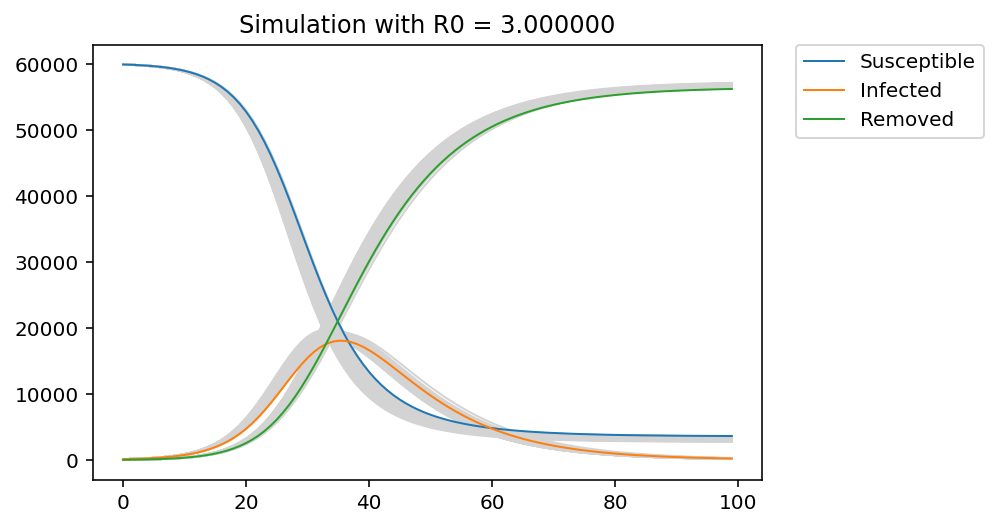

In [39]:
t_grid = np.linspace(0, data_size, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIR, z0, t_grid, args=tuple(parameters[j]))
    plot_traj_gray(simul_yy)

true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento
plot_traj(true_yy)

    
plt.show()

In [31]:
from scipy.stats import wilcoxon, mannwhitneyu, kruskal

mannwhitneyu(parameters[:,2],parameters[:,3])

MannwhitneyuResult(statistic=120080.0, pvalue=0.14067983035202897)

In [61]:
print(np.mean(parameters[:,0] - parameters[:,1] < 0), np.mean(parameters[:,2] - parameters[:,3] > 0) ,np.mean(parameters[:,4] > 0))

0.338 0.474 0.438


In [1]:
import arviz as az

az.ess(parameters[:,1])

NameError: name 'parameters' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
parameters = np.load('Parameters_4/parameters.npy')

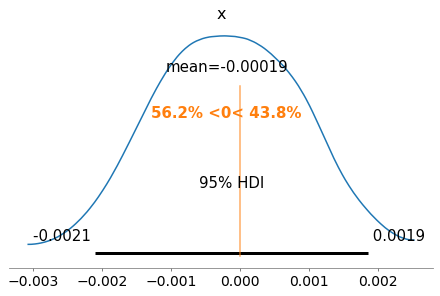

In [14]:
az.plot_posterior(parameters[:,0] - parameters[:,1],hdi_prob = 0.95, ref_val = 0)
plt.savefig('HDI_01.png', dpi=300)

In [44]:
az.hdi(parameters[:,1])

array([0.31366881, 0.34172746])

In [44]:
az.geweke(parameters[:,0])

array([[ 0.00000000e+00,  7.38230244e-02],
       [ 1.30000000e+01,  5.30642211e-02],
       [ 2.60000000e+01,  5.54752472e-02],
       [ 3.90000000e+01, -2.55694901e-02],
       [ 5.20000000e+01,  6.76128159e-02],
       [ 6.50000000e+01,  1.46491152e-02],
       [ 7.80000000e+01, -1.09882106e-02],
       [ 9.10000000e+01,  4.99684813e-02],
       [ 1.05000000e+02,  5.76557978e-04],
       [ 1.18000000e+02,  1.01120758e-01],
       [ 1.31000000e+02,  8.63491974e-02],
       [ 1.44000000e+02,  3.94439798e-02],
       [ 1.57000000e+02,  3.10017413e-02],
       [ 1.70000000e+02,  1.22089706e-01],
       [ 1.83000000e+02,  2.61306757e-02],
       [ 1.96000000e+02, -6.94201720e-02],
       [ 2.10000000e+02, -1.13106900e-01],
       [ 2.23000000e+02, -6.95975442e-02],
       [ 2.36000000e+02,  2.27754780e-02],
       [ 2.49000000e+02, -2.88099066e-02]])

<AxesSubplot:title={'center':'x'}, xlabel='Quantile', ylabel='MCSE for quantiles'>

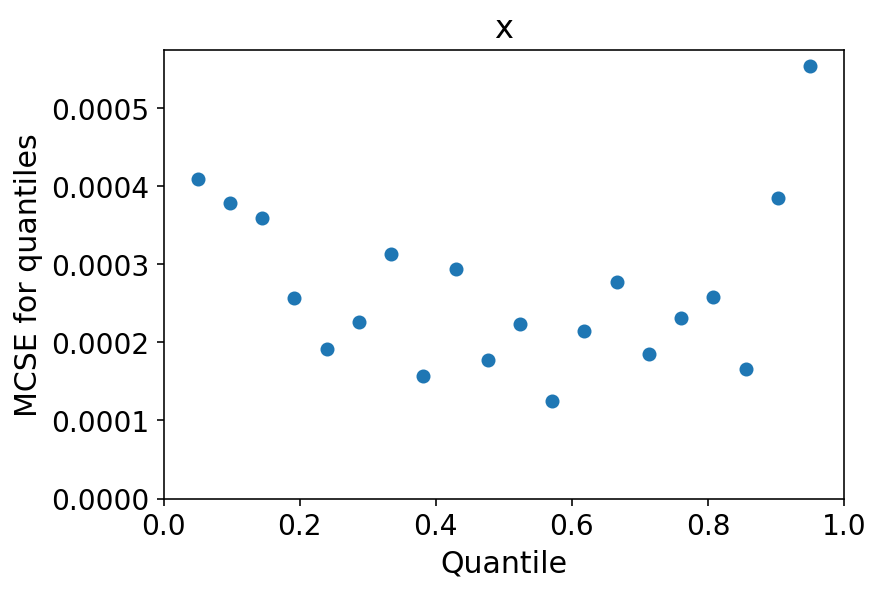

In [49]:
az.plot_mcse(parameters[:,0])

In [46]:
# TO DO

# - simulation with only two parameters
# - go back to noisy simulation
# - thinning
# - weighted noise
# - CI for intensive therapy
# - sensitivity analysis!

# - understand why bayesian
# - sliding window for parameters estimation?
# - non observable states' estimation (through t-1?)
# - different dynamical systems interactions 

# - batch does not really make sense
# -> we always overestimate

In [2]:
import pandas as pd

parameters_ = pd.read_csv('data_weights.csv', header = None, names = ['$\theta 1$', '$\theta 2$', '$\theta 3$', '$\theta 4$'])

AttributeError: 'PairGrid' object has no attribute 'set_title'

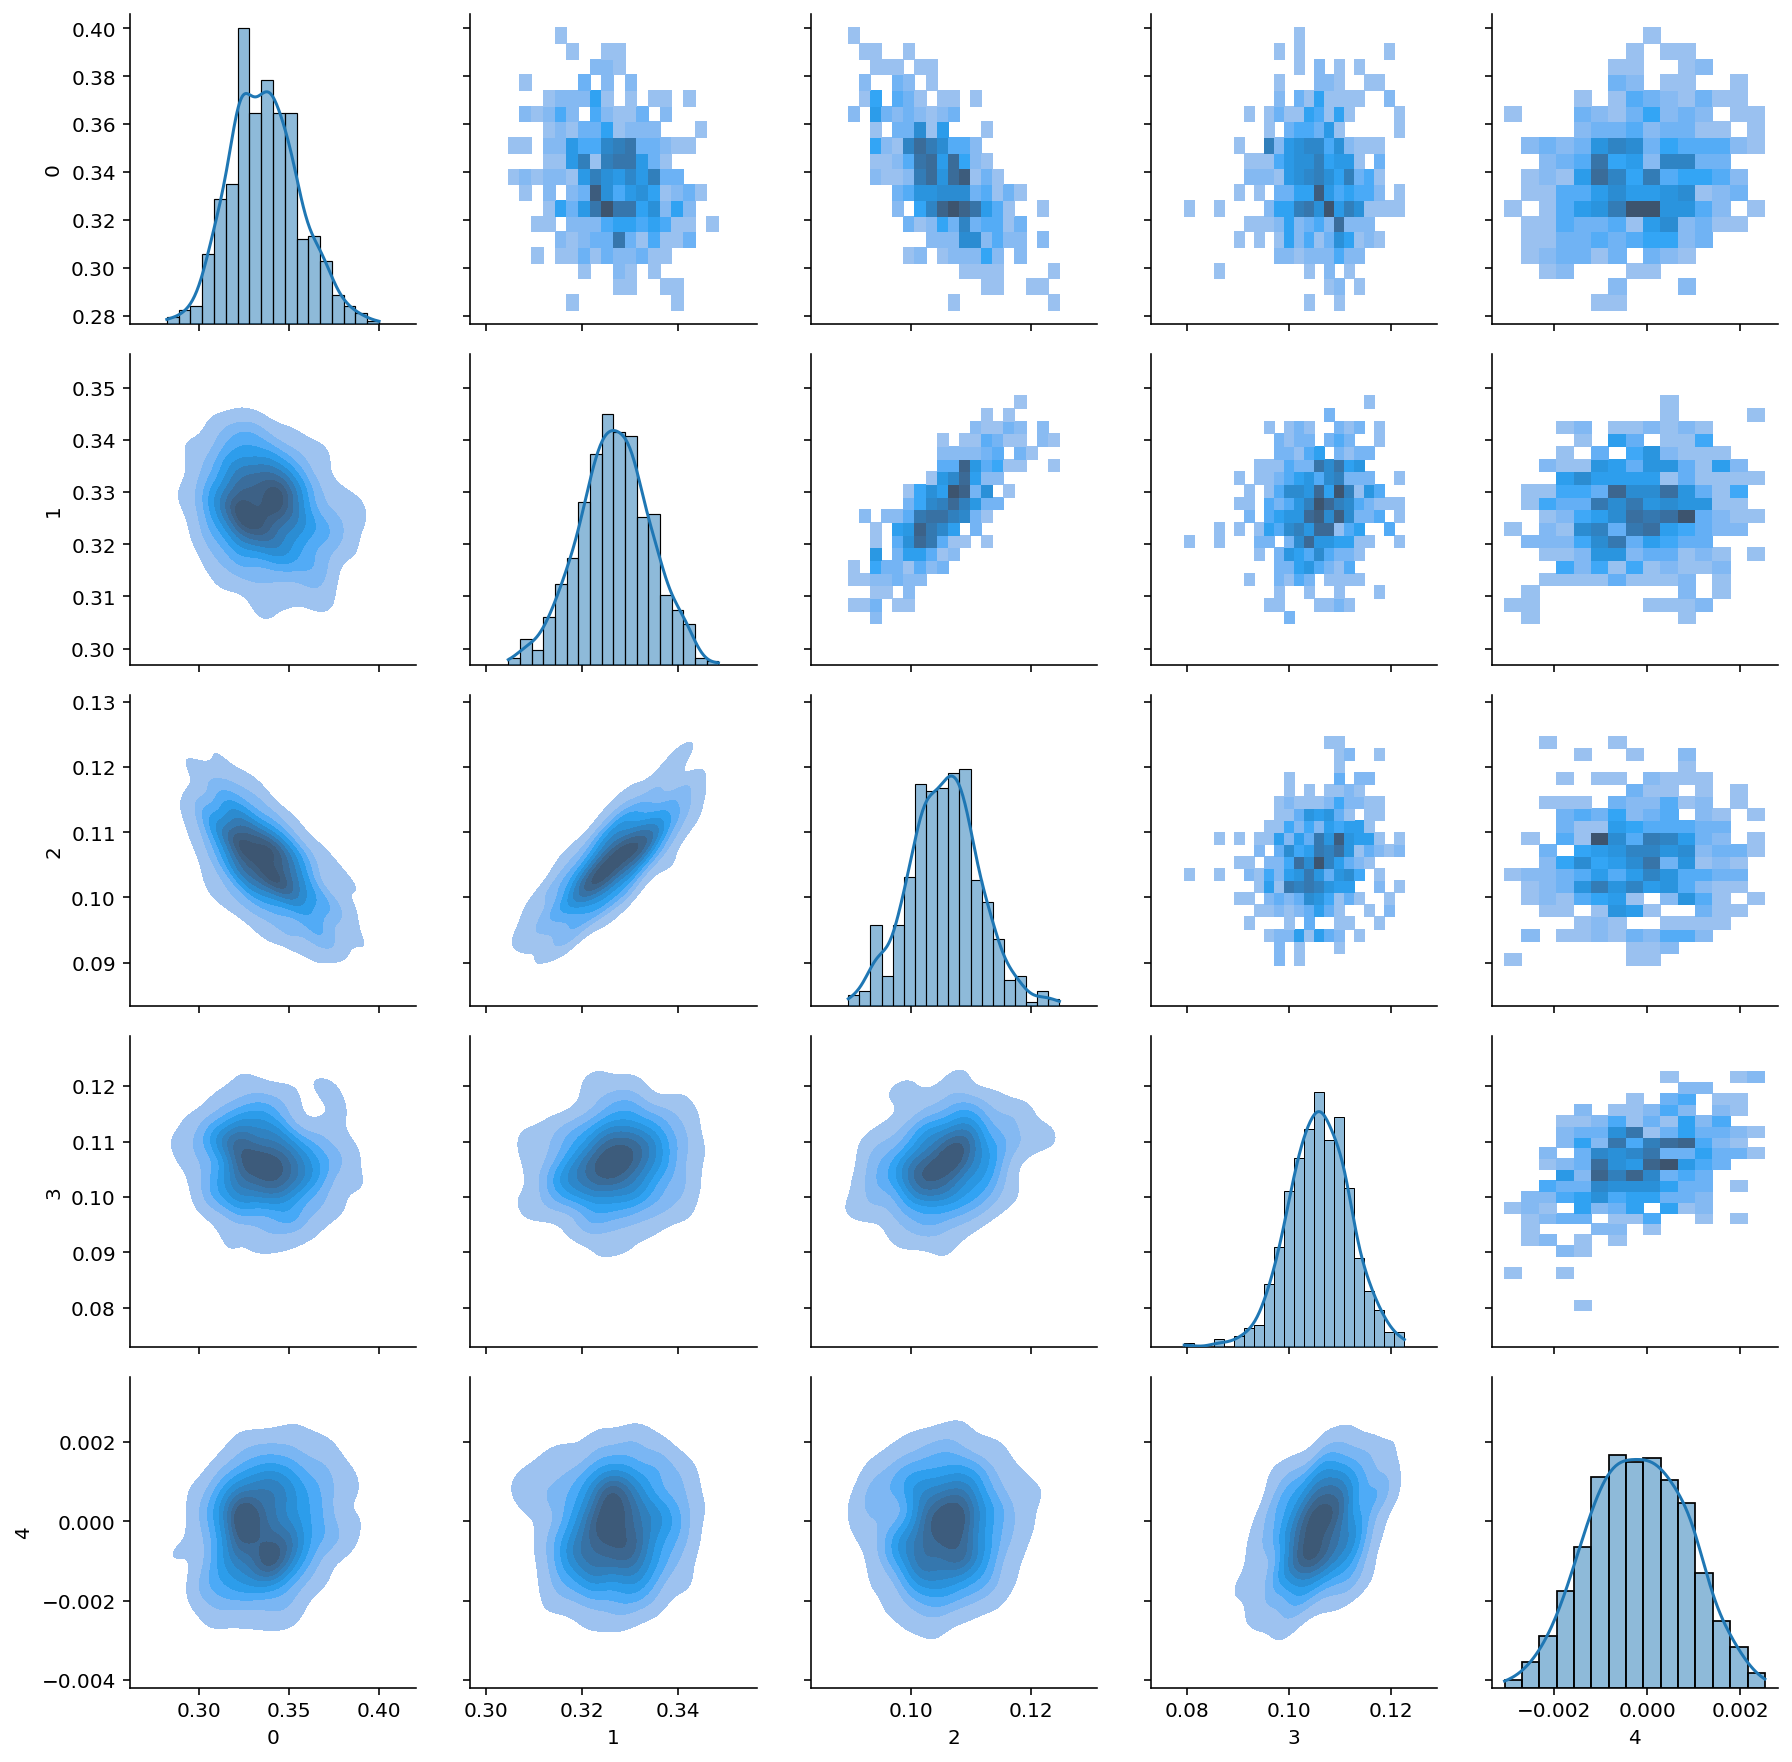

In [12]:
import seaborn as sns
import pandas as pd


g = sns.PairGrid(pd.DataFrame(parameters_))
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)